In [110]:
# Load all packages
from os.path import join
import mat73
import matplotlib.pyplot as plt
import numpy as np
import mne

In [111]:
# Load data into dictionary
DataPath = join("neuro_data","dataSubj10.mat")
data_dict = mat73.loadmat(DataPath, use_attrdict=True)

# Electrode Positions
Here plot the electrode positions with the provided data, and then with my assumptions of the positions.
## With provided data

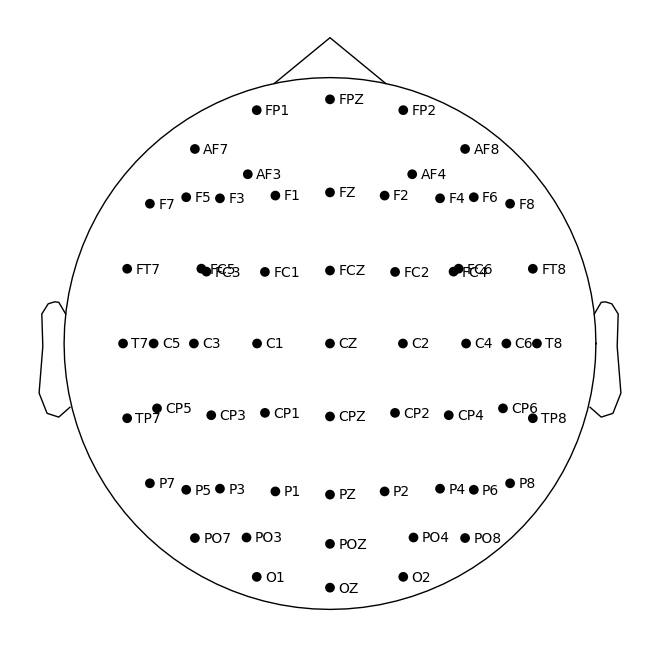

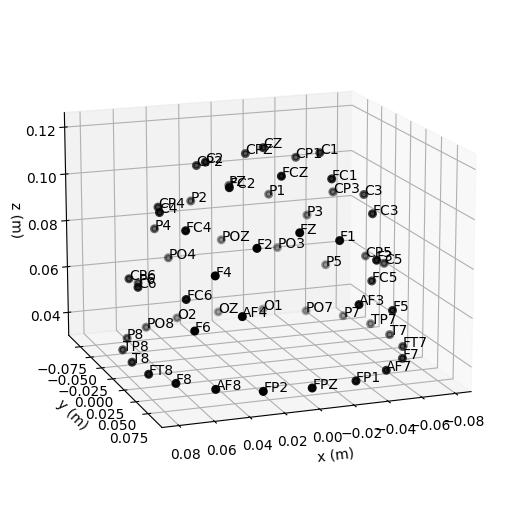

In [112]:
data = data_dict["data"]
# There is only 60 channels worth of measurements, likely corresponding to these. 
# Channel location info includes 74 channels.
used_channels = [ch[0].upper() for ch in data["label"]]
all_channels = [ch[0].upper() for ch in data["elec"]["label"]]
all_locations = data["elec"]["chanpos"]
# Positions of all used channels as dictionary in meters
ch_pos_all = {}
for i, channel in enumerate(all_channels):
    ch_pos_all[channel.upper()]=all_locations[i]/100

ch_pos = {}
for channel in used_channels:
    ch_pos[channel] = ch_pos_all[channel]

easycap_montage = mne.channels.make_dig_montage(ch_pos=ch_pos,coord_frame="head")
easycap_montage.plot(sphere=(0,0,0,0.08))  # 2D, sphere parameter to fit figure and location scale better
fig = easycap_montage.plot(kind='3d', show=False)  # 3D
fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial

## With assumptions
Here I plot with my assumptions, since the positions look slightly off

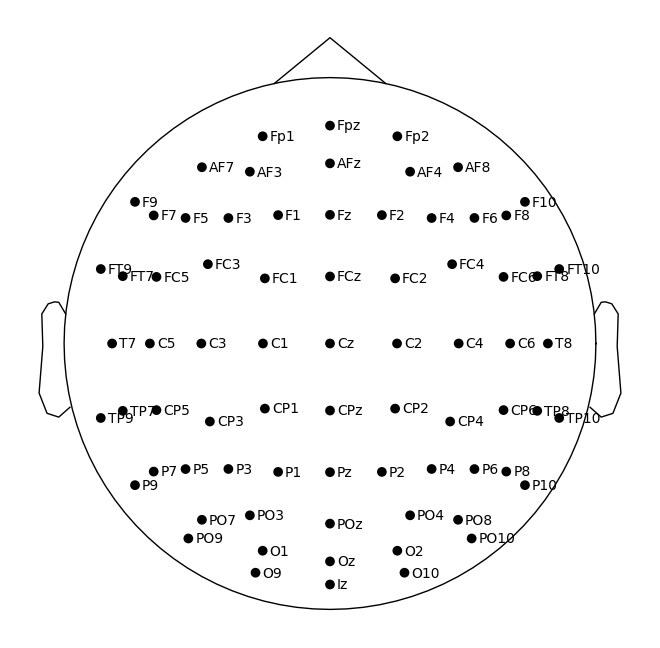

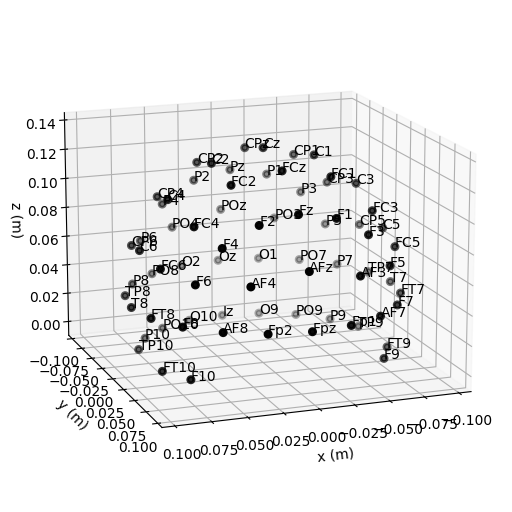

In [113]:
easycap_montage2 = mne.channels.make_standard_montage('easycap-M1')
easycap_montage2.plot()  # 2D
fig = easycap_montage2.plot(kind='3d', show=False)  # 3D
fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial


# Creating MNE data structure
Here we create the MNE datastructure manually from the imported matlab data, as we were not given RAW format.

In [114]:
n_ch = len(used_channels)
channel_types = n_ch*["eeg"]
sfreq = data["fsample"] # sampling frequency, float?
# Metadata for each of the samples.
info = mne.create_info(used_channels, sfreq, channel_types)

# Create datastructure for one sample
n_samples = len(data["trial"])

rawsample = mne.io.RawArray(data["trial"][0],info)

# Create Evoked structure for visualization
trialevoked = mne.EvokedArray(data["trial"][0],info,-2)
#trialevoked.plot(picks="eeg",spatial_colors=True)


Creating RawArray with float64 data, n_channels=60, n_times=4501
    Range : 0 ... 4500 =      0.000 ...     9.000 secs
Ready.


To get standardized location data included, use easycap M1 standard locations, with 74 electrodes, make all the additional electrodes
bad channels, upscale data to reflect appropriate shape.
Shape conversion function:

In [116]:
all_channels = [ch[0] for ch in data["elec"]["label"]] # Not all upper case
used_channel_case = [ch for ch in all_channels if ch.upper() in used_channels] # match cases
bad_channels = list(set(all_channels).difference(set(used_channel_case))) # Channels not used
n_samples = len(data["trial"][0][0]) # Amount of measurements for each channel in a trial

def DimConvertFunc(trial):
    newTrial = np.zeros((len(all_channels),n_samples))
    j = 0
    filler = [0]*n_samples
    for i, ch in enumerate(all_channels):
        if ch in bad_channels:
            newTrial[i]=filler
        else:
            newTrial[i]=trial[j]
            j += 1
    return newTrial

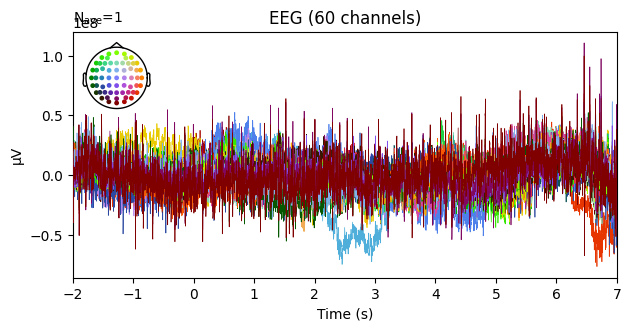

<Info | 9 non-empty values
 bads: 14 items (O9, Iz, FT10, FT9, P9, F9, TP9, F10, PO9, PO10, TP10, ...)
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 74 EEG
 custom_ref_applied: False
 dig: 77 items (3 Cardinal, 74 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 74
 projs: []
 sfreq: 500.0 Hz
>


In [121]:
sfreq = data["fsample"] # sampling frequency, float?
# Metadata for each of the samples.


info = mne.create_info(all_channels, sfreq, "eeg")

info.set_montage('easycap-M1')
info["bads"] = bad_channels

# Create Evoked structure for visualization
dat = DimConvertFunc(data["trial"][0])
trialevoked = mne.EvokedArray(dat,info,-2)
trialevoked.plot(picks="eeg",spatial_colors=True)
print(info)
